In [1]:
import talib
import random
import datetime
import itertools
import pyfolio as pf
import numpy as np 
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
from tqdm import tqdm_notebook
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, optimizers
%matplotlib inline

ModuleNotFoundError: No module named 'talib'

# Data

In [2]:
start = datetime.datetime(2010, 2, 20)
end = datetime.datetime(2021, 2, 20)

In [3]:
stock = pdr.get_data_yahoo('SCB.BK', start=start, end=end)

In [4]:
adx = talib.ADX(stock['High'], stock['Low'], stock['Close'], timeperiod=14)
cci = talib.CCI(stock['High'], stock['Low'], stock['Close'], timeperiod=14)
rsi = talib.RSI(stock['Close'], timeperiod=14)
stock['ADX'] = adx
stock['CCI'] = cci
stock['RSI'] = rsi

In [5]:
data = stock[['Adj Close', 'ADX', 'CCI', 'RSI']].dropna()

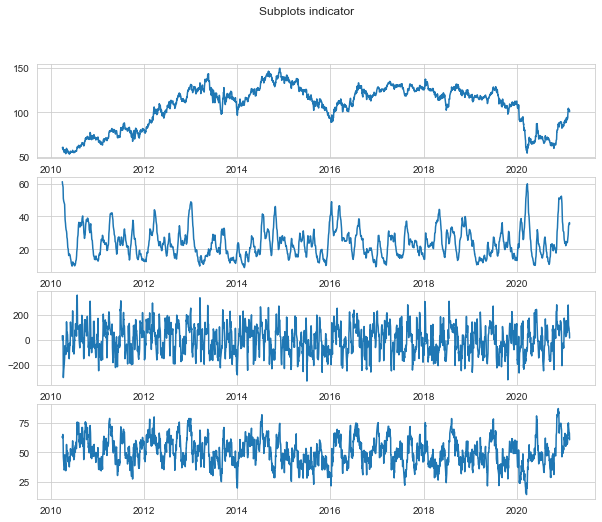

In [6]:
sns.set_style("whitegrid")

fig, axs = plt.subplots(data.shape[1], figsize=(10,8))
fig.suptitle('Subplots indicator')

for i in range(data.shape[1]):
    axs[i].plot(data.iloc[:,i])

plt.show()   

# Train & Test split 

In [7]:
split = int(len(data)*0.7)+1
train_data = data[:split]
test_data = data[split:]

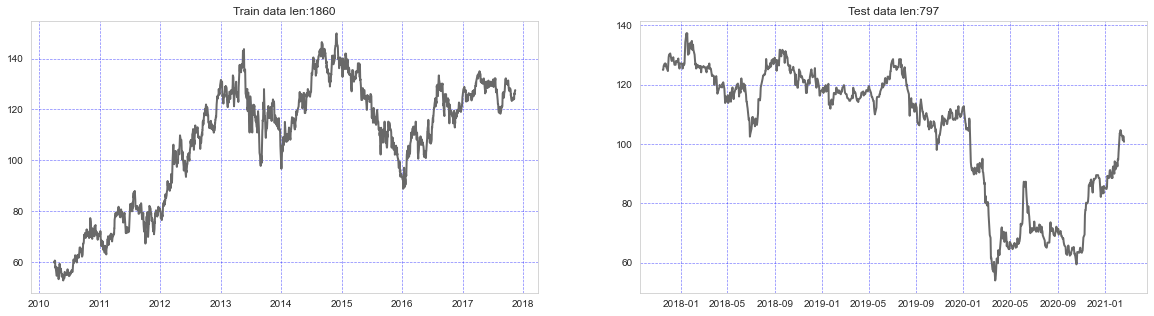

In [8]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

columns = 'Adj Close'
ax1.plot(train_data[columns], color='dimgray',lw=2)
ax1.title.set_text('Train data len:'+str(len(train_data)), )
ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

ax2.plot(test_data[columns], color='dimgray',lw=2)
ax2.title.set_text('Test data len:'+str(len(test_data)))
ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

# Neural Network

In [9]:
class DenseNetwork(models.Model):
    
    def __init__(self,input_sz, output_sz, hidden_sz):
        super(DenseNetwork, self).__init__()
        self.input_layer = layers.InputLayer(input_shape=(input_sz,))
        self.hidden_layer = [layers.Dense(i, activation='relu') for i in hidden_sz]
        self.output_layer = layers.Dense(output_sz, activation = 'linear')
        
    def call(self, x):
        x = self.input_layer(x)
        for l in self.hidden_layer:
            x = l(x)
        return self.output_layer(x)

# Class Agent

In [10]:
class DDQNAgent():

    def __init__(self, 
                 state_size=None, 
                 action_size=None,
                 hidden_size=[64,64],
                 maxlen=10000,
                 lr=0.001,
                 batch_size=128,
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_decay_factor=0.9999,
                 epsilon_min = 0.01,
                 Architecture=DenseNetwork):
        
        self.state_size = state_size  
        self.action_size = action_size  
        
        self.discount_factor = gamma
        self.learning_rate = lr
        self.epsilon = epsilon
        self.epsilon_decay_factor = epsilon_decay_factor 
        self.epsilon_min = epsilon_min
        
        self.hidden_size = hidden_size
        
        self.model = Architecture(self.state_size, self.action_size, self.hidden_size)
        self.target_model = Architecture(self.state_size, self.action_size, self.hidden_size) 
        
        self.copy_weights(self.model, self.target_model)
        
        self.optimizer = tf.keras.optimizers.Adam(lr=self.learning_rate)

        self.maxlen = maxlen
        self.memory = deque(maxlen=self.maxlen) 
        self.batch_size = batch_size
        
        self.losses = []
    
    def __str__(self):
        return "Parameter_Agent(Discount:%s, Epsilon_decay:%s, Maxlen:%s, batch:%s)" %(self.discount_factor, 
                                                                                 self.epsilon_decay_factor, 
                                                                                 self.maxlen, 
                                                                                 self.batch_size)
    
    def copy_weights(self, Copy_from, Copy_to):
        var2 = Copy_from.trainable_variables
        var1 = Copy_to.trainable_variables
        for v1, v2 in zip(var1, var2):
            v1.assign(v2.numpy())

    def get_action(self, state):
        optimal_action = np.argmax(self.model.call(state)[0])
        random_action = random.randint(0, self.action_size - 1)
        action = np.random.choice([optimal_action, random_action], p=[1 - self.epsilon, self.epsilon])
        return action
    
    def save_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_factor
    
    def vanilla_loss(self, target, q):
        return tf.keras.losses.mse(target, q)
    
    def train_model(self):
        if len(self.memory) >= self.batch_size:
            state, action, reward, next_state, done = zip(*random.sample(self.memory, self.batch_size)) 

            state = tf.cast(np.vstack(state), dtype=tf.float32)
            action = tf.squeeze(tf.cast(np.vstack(action), dtype=tf.int32), axis=1) 
            reward = tf.squeeze(tf.cast(np.vstack(reward), dtype=tf.float32))
            next_state = tf.cast(np.vstack(next_state), dtype=tf.float32)
            done = tf.squeeze(tf.cast(np.vstack(done), dtype=tf.float32))
            
            q_target = self.model.call(state)
            target_next = self.model.call(next_state) #For predict argmax next_state
            target_val = self.target_model.call(next_state) #Predict value     

            a = np.argmax(target_next, axis=1)
            target = reward + self.discount_factor * \
                    np.array([target_val[i][a[i]] for i in range(self.batch_size)]) * \
                    (tf.ones(self.batch_size) - done)
            
            q_target = q_target.numpy()
            target = target.numpy()
            
            q_target[np.arange(self.batch_size), list(action)] = target
            q_target = tf.convert_to_tensor(q_target, dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                q_s_a = self.model.call(state)
                
                loss = self.vanilla_loss(q_target, q_s_a)
                self.losses.append(loss.numpy().sum())
                
                gradients = tape.gradient(loss, self.model.trainable_weights)
                
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            return loss  

# Class Env

In [11]:
class GridTradingEnv(): 
    def __init__(self, 
                 data=None, 
                 initial_capital=100000,
                 zone_grid=[0,20],
                 min_limit=100,
                 transaction_cost=0):
        
        self.stock_price_history = data.iloc[:,0]
        self.indicator_history1 = data.iloc[:,1]
        self.indicator_history2 = data.iloc[:,2]
        self.indicator_history3 = data.iloc[:,3]
        self.n_step = self.stock_price_history.shape[0] # n stock
        self.n_stock = 1
        
        self.initial_capital = initial_capital
        self.lower_zone = zone_grid[0]
        self.upper_zone = zone_grid[1]
        self.min_limit = min_limit
        #self.max_pos = 2*self.initial_capital/(self.upper_zone-self.lower_zone)
        self.max_pos = self.initial_capital/((self.upper_zone+self.lower_zone)/2)
        
        self.begin_portfolio_value = initial_capital
        self.transaction_cost = transaction_cost
        
        self.n_buy = None
        self.n_sell = None
        self.marker = None
        self.memory = None
        
        self.cur_step = None
        self.position = None
        self.stock_price = None
        self.indicator1 = None
        self.indicator2 = None
        self.indicator3 = None
        self.cash = None
        
        self.action_list = list(map(list, itertools.product(np.arange(3), repeat=self.n_stock))) 
        self.action_space = np.arange(len(self.action_list)**self.n_stock) 
        self.state_space = 4*self.n_stock
        
        self.reset()
        
    def __str__(self):
        return "Env(Len_data:%s, Capital:%s, Lower_zone:%s, Upper_zone:%s, Max_pos:%.2f, Min_limit:%s)" %(self.n_step,
                                                                                                        self.initial_capital, 
                                                                                                        self.lower_zone, 
                                                                                                        self.upper_zone,
                                                                                                        self.max_pos,
                                                                                                        self.min_limit)
    def strategy_plot(self, plus):
        x1 = np.arange(self.lower_zone-plus, self.upper_zone+plus+1)
        x2 = np.arange(0, self.upper_zone+2)
        y_linear = []
        y_port_val = []
        
        for i in x1:
            y_linear.append(self.linear_func(i))
        for i in x2:
            y_port_val.append(self.port_val_func(i))
            
        fig = plt.figure(figsize=(15,4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        ax1.plot(x1, y_linear)
        ax1.title.set_text('Linear Function')
        ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)
        ax1.set_ylabel('Position')
        ax1.set_xlabel('Price')
        
        ax2.plot(x2, y_port_val)
        ax2.title.set_text('Portfolio Value Curve')
        ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)
        ax2.set_ylabel('Port Value')
        ax2.set_xlabel('Price')
        
        plt.show()
                                                                                  
    def reset(self):
        self.marker = []
        self.memory = []
        self.n_buy = 0
        self.n_sell = 0
        self.cur_step = 0
        self.position = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.indicator1 = self.indicator_history1[self.cur_step]
        self.indicator2 = self.indicator_history2[self.cur_step]
        self.indicator3 = self.indicator_history3[self.cur_step]
        self.cash = self.initial_capital
        return self._get_obs()
        
    def step(self, action):
        assert action in self.action_space
        prev_val = self.port_val()
        
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        self.indicator1 = self.indicator_history1[self.cur_step]
        self.indicator2 = self.indicator_history2[self.cur_step]
        self.indicator3 = self.indicator_history3[self.cur_step]
        
        self._trade(action)
        
        cur_val = self.port_val()
        reward = cur_val - prev_val
        done = self.cur_step == self.n_step - 1
        info = {'cur_val': cur_val}
        
        return self._get_obs(), reward, done, info
    
    def _get_obs(self): 
        obs = np.empty(self.state_space)
        obs[0] = self.stock_price
        obs[1] = self.indicator1
        obs[2] = self.indicator2
        obs[3] = self.indicator3
        return obs
      
    def port_val(self):
        return self.position*self.stock_price + self.cash 
    
    def port_val_func(self, price):
        price = np.min([self.upper_zone, price])
        rect = np.min([self.lower_zone, price])
        y1 = self.linear_func(price)
        port_val = 0.5*(self.max_pos+y1)*(price-rect)+self.max_pos*rect
        return port_val
    
    def linear_func(self, price): 
        x1 = np.max([self.lower_zone, price])
        x2 = np.min([self.upper_zone, x1])
        m = self.max_pos/(self.lower_zone-self.upper_zone)
        y = m*x2 - self.upper_zone*m 
        return y
        
    def _trade(self,action):  
        #sell=0, hold=1, buy=2
        adjust_pos = self.linear_func(self.stock_price)
        diff = adjust_pos-self.position
        
        #sell
        if action==0 and diff<=-self.min_limit and self.position>=abs(diff): 
            self.position -= abs(diff)
            self.cash += self.stock_price*abs(diff)
            self.n_sell += 1
            self.marker.append(0)
        #buy
        elif action==2 and diff>=self.min_limit and self.cash>=self.stock_price*abs(diff): 
            self.position += abs(diff)
            self.cash -= self.stock_price*abs(diff)
            self.n_buy += 1
            self.marker.append(2)
        #hold
        else:
            self.marker.append(1) 
    
    def check_result(self):
        df = pd.DataFrame(self.memory, columns=['Price', 'Adj Position', 'Position', 'Cash', 'Equity Curve', 'Action'])
        return df
    
    def save_result(self, price, adj_pos, pos, cash, equity, act):
        self.memory.append((price, adj_pos, pos, cash, equity, act))
       

# Training

In [13]:
#config
capital = 500000
zone = [60, 140]
minimum_limit = 100

Parameter_Agent(Discount:0.95, Epsilon_decay:0.99995, Maxlen:5000, batch:128)
Env(Len_data:1860, Capital:500000, Lower_zone:60, Upper_zone:140, Max_pos:5000.00, Min_limit:100)


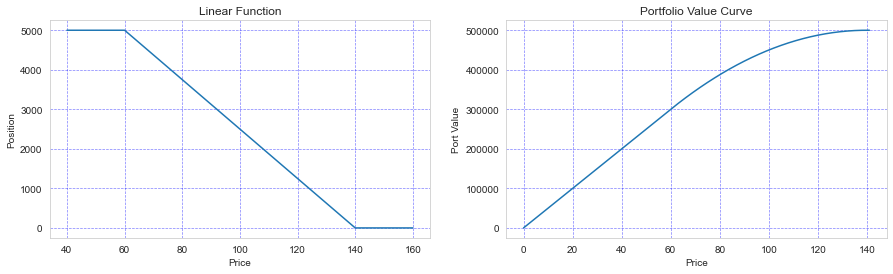

<ipython-input-14-a44fa38bb2f5>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(number_of_episodes)):


  0%|          | 0/500 [00:00<?, ?it/s]

Episode: 1
begin_portfolio_value: 500000.00
end_portfolio_value: 862049.75
total_reward: 362049.75
average_reward: 362049.75
buy: 141, sell: 148
Epsilon: 0.91124
Episode: 26
begin_portfolio_value: 500000.00
end_portfolio_value: 861191.04
total_reward: 361191.04
average_reward: 365284.60
buy: 67, sell: 73
Epsilon: 0.08921


KeyboardInterrupt: 

In [14]:
if __name__ == "__main__":
        
    env = GridTradingEnv(train_data, initial_capital=capital, zone_grid=zone, min_limit=minimum_limit)
    agent = DDQNAgent(env.state_space, len(env.action_space), 
                      hidden_size=[256,256,256,256,256], 
                      gamma=0.95, 
                      epsilon_decay_factor=0.99995, 
                      maxlen=5000) 
    print(agent)
    print(env)
    env.strategy_plot(20)
    
    number_of_episodes = 500
    total_reward = np.zeros(number_of_episodes)  
    data
    train_freq = 10
    
    #random scaler
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    
    for i in tqdm_notebook(range(number_of_episodes)):
        count = 0
        state = env.reset()
        state = scaler.transform([state])
        
        while True:
            count += 1
            
            action = agent.get_action(state)
           
            next_state, reward, done, info = env.step(action)
            next_state = scaler.transform([next_state])

            agent.save_sample(state, action, reward, next_state, done)
            env.save_result(env.stock_price.item(), 
                         env.linear_func(env.stock_price).item(),
                         env.position.item(),
                         np.array(env.cash).item(),
                         env.port_val().item(),
                         action)
            
            if count % train_freq == 0:
                agent.train_model()
            
            #Update Value
            state = next_state
            total_reward[i] += reward 
    
            if done:
                
                agent.copy_weights(agent.model, agent.target_model)
                
                if total_reward[i]>=total_reward.max():
                    agent.model.save_weights('test_high_SCB.h5')
                    
                '''text_file = open("Plot.txt", "a")
                text_file.write('{}\n'.format(total_reward[i]))
                text_file.close()'''
                
                if i % 25 == 0:
                    print(f'Episode: {i+1}')
                    print(f'begin_portfolio_value: {env.begin_portfolio_value:.2f}')
                    print(f'end_portfolio_value: {env.port_val().item():.2f}')
                    print(f'total_reward: {total_reward[i]:.2f}')
                    print(f'average_reward: {total_reward[:i+1].mean():.2f}')
                    print(f'buy: {env.n_buy}, sell: {env.n_sell}')
                    print(f'Epsilon: {agent.epsilon:.5f}')
                    print("=======================================")

                break   
    
    #Save model 
    agent.model.save_weights('test_SCB.h5')
        
    plt.plot(total_reward, color='darkorange')
    plt.plot(talib.EMA(total_reward, timeperiod=20))
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Performance',fontsize=18)
    plt.show()                       
            

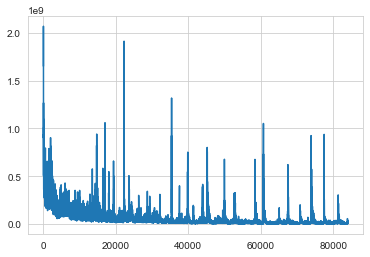

In [35]:
plt.plot(agent.losses)

# Backtesting

In [13]:
backtest_data = train_data #set data <-----------------

env = GridTradingEnv(backtest_data, initial_capital=capital, zone_grid=zone, min_limit=minimum_limit)

#Set weight neural network
backtest_model = DenseNetwork(env.state_space, len(env.action_space), [256,256,256,256,256])
backtest_model.build((None, env.state_space))
backtest_model.load_weights('test_SCB.h5')

========Backtesting Performance========
begin_portfolio_value: 500000.00
end_portfolio_value: 934171.95
total_profit: 434171.95
%profit: 86.83 %
buy: 97, sell: 61


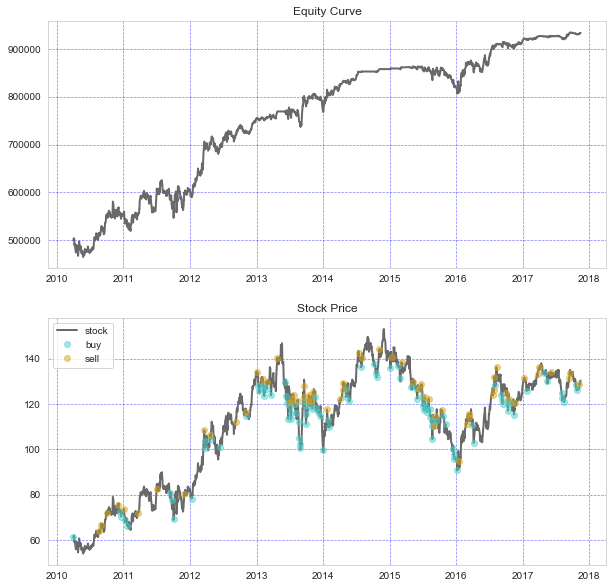

In [14]:
states = []
for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
        break
scaler = StandardScaler()
scaler.fit(states)

state = env.reset()
state = scaler.transform([state])
    
equity_curve = np.empty([env.n_step-1])
total_reward = np.zeros(1)
i = 0
    
while True:

    action = np.argmax(backtest_model.call(state)[0])
    equity_curve[i] =  env.port_val()

    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    
    env.save_result(env.stock_price.item(), 
                         env.linear_func(env.stock_price).item(),
                         env.position.item(),
                         np.array(env.cash).item(),
                         env.port_val().item(),
                         action)

    total_reward += reward
    state = next_state
    i += 1
  
    if done:

        print(f'========Backtesting Performance========')
        print(f'begin_portfolio_value: {env.begin_portfolio_value:.2f}')
        print(f'end_portfolio_value: {env.port_val()[0]:.2f}')
        print(f'total_profit: {total_reward[0]:.2f}')
        print(f'%profit: {total_reward[0]/env.begin_portfolio_value*100:.2f} %')
        print(f'buy: {env.n_buy}, sell: {env.n_sell}')
        print("=======================================")

        break

def result4plot(data, action, port_val):
    data = data.drop(data.index[0])
    data['Action'] = np.array(action)
    data['Equity Curve'] = np.array(port_val)
    marker = data.drop(data.columns[[1, 2, 3]], axis=1)
    eqtc = data.drop(data.columns[[0, 1, 2, 3, 4]], axis=1)
    return marker, eqtc, data

#Set marker buy&sell
marker, eqtc, bt_data = result4plot(backtest_data, env.marker, env.check_result()['Equity Curve'])
marker_buy = marker[marker['Action']==2].iloc[:,0]
marker_sell = marker[marker['Action']==0].iloc[:,0]

#Plot Visualization
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(eqtc, color='dimgray',lw=2)
ax1.title.set_text('Equity Curve')
ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

ax2.plot(bt_data.iloc[:,0], color='dimgray',lw=2)
ax2.plot(marker_buy, 'o', color='mediumturquoise', lw=0.1, alpha=0.5)
ax2.plot(marker_sell, 'o', color='goldenrod', lw=0.1, alpha=0.5)
ax2.title.set_text('Stock Price')
ax2.legend(['stock','buy','sell'])
ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

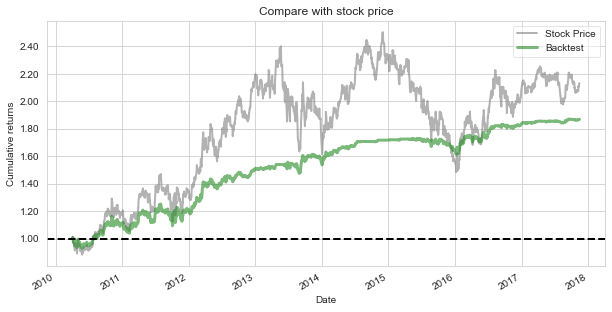

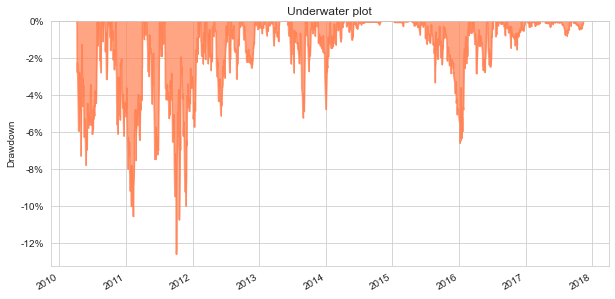

In [15]:
#PLot compare with benchmark
plt.figure(figsize=(10,5));
eqtc = eqtc.squeeze()
bt_data = bt_data.rename(columns = {'Adj Close': 'Stock Price'})

pf.plotting.plot_rolling_returns(eqtc.pct_change(), bt_data.iloc[:,0].pct_change());
plt.title('Compare with stock price');

plt.figure(figsize=(10,5));
pf.plot_drawdown_underwater(eqtc.pct_change());

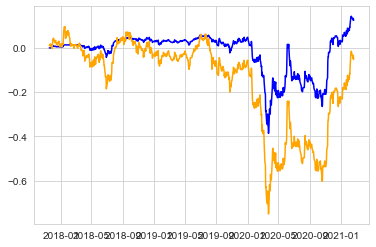

In [27]:
plt.plot(eqtc.pct_change().cumsum(),'b')
plt.plot(bt_data.iloc[:,0].pct_change().cumsum(),'orange')